## 1. Setup Inicial

In [1]:
# Verificar GPU
!nvidia-smi

Sat Dec 13 19:58:50 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.105.08             Driver Version: 580.105.08     CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4050 ...    Off |   00000000:01:00.0 Off |                  N/A |
| N/A   42C    P8              1W /   60W |     110MiB /   6141MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
# Instalar dependências
!pip install -q segmentation-models-pytorch albumentations pyyaml kaggle

In [2]:
# Imports
import os
import pathlib
import yaml
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.amp import autocast, GradScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm.notebook import tqdm
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader
import segmentation_models_pytorch as smp
from torchvision import models

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.9.1+cu130
CUDA available: True
CUDA device: NVIDIA GeForce RTX 4050 Laptop GPU


## 2. Verificar Dataset Local

In [4]:
# Verificar se o dataset existe no caminho local
BASE_DIR = pathlib.Path("../data/")

if BASE_DIR.exists():
    print(f"✓ Dataset encontrado em: {BASE_DIR.absolute()}")
    print(f"\nConteúdo:")
    for item in sorted(BASE_DIR.iterdir()):
        if item.is_dir():
            count = len(list(item.rglob('*')))
            print(f"  📁 {item.name}/ ({count} arquivos)")
        else:
            print(f"  📄 {item.name}")
    
    # Verificar estrutura essencial
    train_img_dir = BASE_DIR / "train_images"
    if train_img_dir.exists():
        authentic = train_img_dir / "authentic"
        forged = train_img_dir / "forged"
        if authentic.exists() and forged.exists():
            print(f"\n✓ Estrutura OK:")
            print(f"  • Autênticas: {len(list(authentic.glob('*')))} imagens")
            print(f"  • Falsificadas: {len(list(forged.glob('*')))} imagens")
        else:
            print("\n⚠ Estrutura incompleta: faltam pastas authentic/forged")
    else:
        print("\n⚠ Pasta train_images não encontrada")
else:
    print(f"✗ Dataset NÃO encontrado em: {BASE_DIR.absolute()}")
    print("\nVerifique o caminho do dataset!")

✓ Dataset encontrado em: /home/luan/Documents/ia_the_movie/notebooks/../data

Conteúdo:
  📄 sample_submission.csv
  📁 supplemental_images/ (48 arquivos)
  📁 supplemental_masks/ (48 arquivos)
  📁 test_images/ (1 arquivos)
  📁 train_images/ (5130 arquivos)
  📁 train_masks/ (2751 arquivos)

✓ Estrutura OK:
  • Autênticas: 2377 imagens
  • Falsificadas: 2751 imagens


## 3. Configuração

In [5]:
# Configuração do projeto - OTIMIZADA PARA GPU LOCAL
config = {
    'paths': {
        'data_dir': '../data',
        'train_images': '../data/train_images',
        'train_masks': '../data/train_masks',
        'checkpoints_dir': './checkpoints',
        'results_dir': './results',
    },
    'dataset': {
        'image_size': 256,  # Reduzido de 512 para 256 - muito mais rápido
        'train_split': 0.8,
        'batch_size': 32,  # Ajustado para RTX 4050 (6GB VRAM)
        'num_workers': 2,  # Ajustado para máquina local
        'pin_memory': True,
        'seed': 42,
    },
    'training': {
        'epochs': 20,  # Aumentado para dar mais chances
        'patience': 15,  # Aumentado de 10 para 15 épocas de paciência
        'learning_rate': 0.0003,  # Reduzido de 0.001 - mais estável
        'weight_decay': 0.0001,
        'optimizer': 'adam',
        'scheduler': 'reduce_on_plateau',
        'mixed_precision': True,
        'clip_grad_norm': 1.0,
    },
    'models': {
        'simple_cnn': {
            'num_classes': 2,
            'base_filters': 64,  # Aumentado de 32 para 64 - mais capacidade
        },
        'resnet_transfer': {
            'num_classes': 2,
            'pretrained': True,
            'freeze_backbone': False,
        },
        'unet_segmentation': {
            'encoder_name': 'resnet34',
            'encoder_weights': 'imagenet',
            'in_channels': 3,
            'classes': 1,
        },
    },
}

# Criar diretórios
os.makedirs(config['paths']['checkpoints_dir'], exist_ok=True)
os.makedirs(config['paths']['results_dir'], exist_ok=True)

# Seed
torch.manual_seed(config['dataset']['seed'])
np.random.seed(config['dataset']['seed'])

print("✓ Configuração OTIMIZADA carregada")
print(f"  • Image size: {config['dataset']['image_size']}x{config['dataset']['image_size']}")
print(f"  • Batch size: {config['dataset']['batch_size']} (RTX 4050 6GB)")
print(f"  • Num workers: {config['dataset']['num_workers']}")
print(f"  • Patience: {config['training']['patience']} épocas")
print(f"  • Learning rate: {config['training']['learning_rate']}")
print(f"  • Checkpoints: {config['paths']['checkpoints_dir']}")
print(f"  • Resultados: {config['paths']['results_dir']}")

✓ Configuração OTIMIZADA carregada
  • Image size: 256x256
  • Batch size: 32 (RTX 4050 6GB)
  • Num workers: 2
  • Patience: 15 épocas
  • Learning rate: 0.0003
  • Checkpoints: ./checkpoints
  • Resultados: ./results


## 4. Dataset Classes

In [7]:
class ForgeryClassificationDataset(Dataset):
    """Dataset para classificação: authentic vs forged"""
    
    def __init__(self, authentic_dir, forged_dir, transform=None):
        self.transform = transform
        
        # Carregar paths
        self.authentic_images = sorted(list(Path(authentic_dir).glob('*.jpg')) + 
                                      list(Path(authentic_dir).glob('*.png')))
        self.forged_images = sorted(list(Path(forged_dir).glob('*.jpg')) + 
                                   list(Path(forged_dir).glob('*.png')))
        
        self.images = self.authentic_images + self.forged_images
        self.labels = [0] * len(self.authentic_images) + [1] * len(self.forged_images)
        
        print(f"Dataset: {len(self.authentic_images)} autênticas, {len(self.forged_images)} falsificadas")
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path = str(self.images[idx])
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = self.labels[idx]
        
        if self.transform:
            transformed = self.transform(image=image)
            image = transformed['image']
        
        return image, label


class ForgerySegmentationDataset(Dataset):
    """Dataset para segmentação"""
    
    def __init__(self, images_dir, masks_dir, transform=None, include_authentic=True):
        self.images_dir = Path(images_dir)
        self.masks_dir = Path(masks_dir)
        self.transform = transform
        
        mask_files = sorted(list(Path(masks_dir).glob('*.npy')))
        self.samples = []
        
        # Imagens com máscaras
        for mask_path in mask_files:
            img_id = mask_path.stem
            img_path = self.images_dir / 'forged' / f"{img_id}.jpg"
            if not img_path.exists():
                img_path = self.images_dir / 'forged' / f"{img_id}.png"
            
            if img_path.exists():
                test_img = cv2.imread(str(img_path))
                if test_img is not None:
                    self.samples.append({'image': img_path, 'mask': mask_path, 'has_forgery': True})
        
        # Imagens autênticas
        if include_authentic:
            authentic_dir = self.images_dir / 'authentic'
            if authentic_dir.exists():
                authentic_images = list(authentic_dir.glob('*.jpg')) + list(authentic_dir.glob('*.png'))
                for img_path in authentic_images[:len(self.samples)]:
                    test_img = cv2.imread(str(img_path))
                    if test_img is not None:
                        self.samples.append({'image': img_path, 'mask': None, 'has_forgery': False})
        
        print(f"Segmentation dataset: {len(self.samples)} amostras")
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        sample = self.samples[idx]
        
        image = cv2.imread(str(sample['image']))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if sample['mask'] is not None:
            mask = np.load(str(sample['mask']))
            mask = (mask > 0).astype(np.float32)
            if mask.shape[0] != image.shape[0] or mask.shape[1] != image.shape[1]:
                mask = cv2.resize(mask, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_NEAREST)
        else:
            mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.float32)
        
        if self.transform:
            transformed = self.transform(image=image, mask=mask)
            image = transformed['image']
            mask = transformed['mask']
        
        mask = mask.unsqueeze(0)
        return image, mask

print("✓ Dataset classes definidas")

✓ Dataset classes definidas


## 5. Transformações e Data Loaders

In [8]:
def get_transforms(image_size=512, mode='train'):
    if mode == 'train':
        return A.Compose([
            A.Resize(image_size, image_size),
            # Augmentations mais fortes para melhor generalização
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.Rotate(limit=30, p=0.6),  # Aumentado de 15 para 30 graus
            A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=0, p=0.5),
            A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.6),
            A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
            A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),  # Adicionar ruído
            A.GaussianBlur(blur_limit=(3, 5), p=0.3),  # Blur ocasional
            A.CoarseDropout(max_holes=8, max_height=32, max_width=32, p=0.3),  # Cutout
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2()
        ])
    else:
        return A.Compose([
            A.Resize(image_size, image_size),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2()
        ])

print("✓ Transformações APRIMORADAS definidas")
print("  • Rotação até 30°")
print("  • ShiftScaleRotate para variações")
print("  • GaussNoise e GaussianBlur")
print("  • CoarseDropout (Cutout) para regularização")

✓ Transformações APRIMORADAS definidas
  • Rotação até 30°
  • ShiftScaleRotate para variações
  • GaussNoise e GaussianBlur
  • CoarseDropout (Cutout) para regularização


## 6. Modelos

In [9]:
class ResidualBlock(nn.Module):
    """Bloco residual para melhor fluxo de gradiente"""
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        # Shortcut connection
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
    
    def forward(self, x):
        residual = self.shortcut(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += residual  # Residual connection
        out = self.relu(out)
        return out


class SimpleCNN(nn.Module):
    """CNN APRIMORADA com Residual Blocks e técnicas modernas"""
    
    def __init__(self, num_classes=2, base_filters=32):
        super(SimpleCNN, self).__init__()
        
        # Stem: processamento inicial
        self.stem = nn.Sequential(
            nn.Conv2d(3, base_filters, 7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(base_filters),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2, padding=1)
        )
        
        # Blocos residuais progressivos
        self.layer1 = self._make_layer(base_filters, base_filters*2, 2)
        self.layer2 = self._make_layer(base_filters*2, base_filters*4, 2)
        self.layer3 = self._make_layer(base_filters*4, base_filters*8, 2)
        self.layer4 = self._make_layer(base_filters*8, base_filters*16, 2)
        
        # Attention mechanism (Squeeze-and-Excitation)
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(base_filters*16, base_filters*4, 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(base_filters*4, base_filters*16, 1),
            nn.Sigmoid()
        )
        
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        
        # Classificador com mais capacidade
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(base_filters*16, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )
    
    def _make_layer(self, in_channels, out_channels, num_blocks):
        layers = []
        # Primeiro bloco com stride=2 para downsampling
        layers.append(ResidualBlock(in_channels, out_channels, stride=2))
        # Blocos subsequentes
        for _ in range(num_blocks - 1):
            layers.append(ResidualBlock(out_channels, out_channels, stride=1))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.stem(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        # Aplicar SE attention
        se_weight = self.se(x)
        x = x * se_weight
        
        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


class ResNet50Transfer(nn.Module):
    """Transfer Learning APRIMORADO com ResNet50"""
    
    def __init__(self, num_classes=2, pretrained=True):
        super(ResNet50Transfer, self).__init__()
        
        if pretrained:
            self.backbone = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
        else:
            self.backbone = models.resnet50(weights=None)
        
        num_features = self.backbone.fc.in_features
        
        # Classificador mais robusto
        self.backbone.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(num_features, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )
    
    def forward(self, x):
        return self.backbone(x)


def get_unet(encoder_name='resnet34', encoder_weights='imagenet', classes=1):
    """U-Net para segmentação"""
    return smp.Unet(
        encoder_name=encoder_name,
        encoder_weights=encoder_weights,
        in_channels=3,
        classes=classes,
        activation=None
    )

print("✓ Modelos APRIMORADOS definidos")
print("  SimpleCNN:")
print("    • Residual blocks para melhor gradiente")
print("    • Squeeze-and-Excitation attention")
print("    • BatchNorm em todas as camadas")
print("    • Classificador mais profundo")
print("  ResNet50Transfer:")
print("    • Head com 3 camadas + BatchNorm")
print("    • Dropout progressivo (0.5 → 0.3)")

✓ Modelos APRIMORADOS definidos
  SimpleCNN:
    • Residual blocks para melhor gradiente
    • Squeeze-and-Excitation attention
    • BatchNorm em todas as camadas
    • Classificador mais profundo
  ResNet50Transfer:
    • Head com 3 camadas + BatchNorm
    • Dropout progressivo (0.5 → 0.3)


## 7. Loss Functions e Métricas

In [10]:
class LabelSmoothingCrossEntropy(nn.Module):
    """CrossEntropyLoss com Label Smoothing para melhor generalização"""
    def __init__(self, smoothing=0.1):
        super().__init__()
        self.smoothing = smoothing
        self.confidence = 1.0 - smoothing
    
    def forward(self, predictions, targets):
        log_probs = torch.nn.functional.log_softmax(predictions, dim=-1)
        nll_loss = -log_probs.gather(dim=-1, index=targets.unsqueeze(1))
        nll_loss = nll_loss.squeeze(1)
        smooth_loss = -log_probs.mean(dim=-1)
        loss = self.confidence * nll_loss + self.smoothing * smooth_loss
        return loss.mean()


class FocalLoss(nn.Module):
    """Focal Loss para lidar com desbalanceamento de classes"""
    def __init__(self, alpha=0.25, gamma=2.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
    
    def forward(self, predictions, targets):
        ce_loss = F.cross_entropy(predictions, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        return focal_loss.mean()


class DiceBCELoss(nn.Module):
    def __init__(self, dice_weight=0.5, bce_weight=0.5):
        super().__init__()
        self.dice_weight = dice_weight
        self.bce_weight = bce_weight
        self.bce = nn.BCEWithLogitsLoss()
    
    def forward(self, predictions, targets):
        # Dice Loss
        predictions_sigmoid = torch.sigmoid(predictions)
        predictions_flat = predictions_sigmoid.view(-1)
        targets_flat = targets.view(-1)
        intersection = (predictions_flat * targets_flat).sum()
        dice_loss = 1 - (2. * intersection + 1) / (predictions_flat.sum() + targets_flat.sum() + 1)
        
        # BCE Loss
        bce_loss = self.bce(predictions, targets)
        
        return self.dice_weight * dice_loss + self.bce_weight * bce_loss


def calculate_metrics(predictions, targets, is_segmentation=False):
    """Calcula métricas"""
    if is_segmentation:
        # Métricas de segmentação
        preds = torch.sigmoid(predictions) > 0.5
        preds_flat = preds.view(-1).cpu().numpy()
        targets_flat = targets.view(-1).cpu().numpy()
        
        intersection = (preds_flat * targets_flat).sum()
        union = preds_flat.sum() + targets_flat.sum() - intersection
        iou = (intersection + 1e-6) / (union + 1e-6)
        dice = (2. * intersection + 1e-6) / (preds_flat.sum() + targets_flat.sum() + 1e-6)
        
        return {'iou': iou, 'dice': dice}
    else:
        # Métricas de classificação
        preds = predictions.argmax(dim=1).cpu().numpy()
        targets_np = targets.cpu().numpy()
        
        # Calcular probabilidades para AUC-ROC
        probs = torch.softmax(predictions, dim=1)[:, 1].detach().cpu().numpy()
        
        metrics = {
            'accuracy': accuracy_score(targets_np, preds),
            'precision': precision_score(targets_np, preds, zero_division=0),
            'recall': recall_score(targets_np, preds, zero_division=0),
            'f1_score': f1_score(targets_np, preds, zero_division=0)
        }
        
        # AUC-ROC apenas se houver ambas as classes
        if len(np.unique(targets_np)) > 1:
            metrics['auc_roc'] = roc_auc_score(targets_np, probs)
        else:
            metrics['auc_roc'] = 0.0
            
        return metrics

print("✓ Loss Functions APRIMORADAS e métricas definidas")
print("  • LabelSmoothingCrossEntropy (smoothing=0.1)")
print("  • FocalLoss para classes desbalanceadas")
print("  • DiceBCELoss para segmentação")
print("  • Métricas incluem AUC-ROC")

✓ Loss Functions APRIMORADAS e métricas definidas
  • LabelSmoothingCrossEntropy (smoothing=0.1)
  • FocalLoss para classes desbalanceadas
  • DiceBCELoss para segmentação
  • Métricas incluem AUC-ROC


## 8. Função de Treinamento

In [11]:
def train_model(model, train_loader, val_loader, config, model_name, is_segmentation=False):
    """Treina o modelo"""
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    
    # Loss Function - escolha baseada no LOSS_TYPE
    if is_segmentation:
        criterion = DiceBCELoss()
        print(f"Loss: DiceBCELoss")
    else:
        if LOSS_TYPE == 'label_smoothing':
            criterion = LabelSmoothingCrossEntropy(smoothing=0.1)
            print(f"Loss: LabelSmoothingCrossEntropy (smoothing=0.1)")
        elif LOSS_TYPE == 'focal':
            criterion = FocalLoss(alpha=0.25, gamma=2.0)
            print(f"Loss: FocalLoss (alpha=0.25, gamma=2.0)")
        else:  # cross_entropy
            criterion = nn.CrossEntropyLoss()
            print(f"Loss: CrossEntropyLoss")
    
    # Optimizer com ajustes
    optimizer = torch.optim.AdamW(  # AdamW é melhor que Adam
        model.parameters(),
        lr=config['training']['learning_rate'],
        weight_decay=config['training']['weight_decay'],
        betas=(0.9, 0.999)
    )
    
    # Scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=5
    )
    
    # Mixed precision
    scaler = GradScaler('cuda') if config['training']['mixed_precision'] else None
    
    # Tracking
    history = {'train_loss': [], 'val_loss': [], 'val_metric': []}
    best_metric = 0
    patience_counter = 0
    
    print(f"\nTreinando {model_name}...\n")
    
    for epoch in range(config['training']['epochs']):
        # TRAIN
        model.train()
        train_loss = 0
        
        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{config["training"]["epochs"]} [Train]')
        for images, targets in pbar:
            images = images.to(device)
            targets = targets.to(device)
            
            optimizer.zero_grad()
            
            if scaler:
                with autocast(device_type='cuda', enabled=True):
                    outputs = model(images)
                    loss = criterion(outputs, targets)
                
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                outputs = model(images)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()
            
            train_loss += loss.item()
            pbar.set_postfix({'loss': train_loss / (pbar.n + 1)})
        
        train_loss /= len(train_loader)
        
        # VALIDATION
        model.eval()
        val_loss = 0
        all_preds = []
        all_targets = []
        
        with torch.no_grad():
            for images, targets in val_loader:
                images = images.to(device)
                targets = targets.to(device)
                
                outputs = model(images)
                loss = criterion(outputs, targets)
                
                val_loss += loss.item()
                all_preds.append(outputs)
                all_targets.append(targets)
        
        val_loss /= len(val_loader)
        
        # Métricas
        all_preds = torch.cat(all_preds)
        all_targets = torch.cat(all_targets)
        metrics = calculate_metrics(all_preds, all_targets, is_segmentation)
        
        main_metric = metrics.get('iou', metrics.get('f1_score', 0))
        
        # Scheduler step
        scheduler.step(main_metric)
        
        # Log
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['val_metric'].append(main_metric)
        
        print(f"Epoch {epoch+1}: train_loss={train_loss:.4f}, val_loss={val_loss:.4f}, metric={main_metric:.4f}")
        
        # Save best
        if main_metric > best_metric:
            best_metric = main_metric
            patience_counter = 0
            torch.save(model.state_dict(), f"{config['paths']['checkpoints_dir']}/{model_name}_best.pth")
            print(f"  ✓ Novo melhor modelo! Métrica: {best_metric:.4f}")
        else:
            patience_counter += 1
        
        # Early stopping
        if patience_counter >= config['training']['patience']:
            print(f"\nEarly stopping após {epoch+1} epochs")
            break
    
    print(f"\nTreinamento concluído! Melhor métrica: {best_metric:.4f}\n")
    return history, best_metric

print("✓ Função de treinamento definida")

✓ Função de treinamento definida


## 9. ESCOLHA O MODELO PARA TREINAR

In [13]:
# ========== CONFIGURAÇÕES DE TREINAMENTO ==========
# ESCOLHA O MODELO:
MODEL_TO_TRAIN = 'resnet_transfer'  # 'simple_cnn', 'resnet_transfer', ou 'unet_segmentation'

# ESCOLHA A LOSS FUNCTION (para classificação):
LOSS_TYPE = 'label_smoothing'  # 'cross_entropy', 'label_smoothing', ou 'focal'

# HIPERPARÂMETROS AJUSTÁVEIS:
LEARNING_RATE = 0.0003  # Learning rate inicial
WEIGHT_DECAY = 0.0001   # Regularização L2
BATCH_SIZE = 64        # Tamanho do batch (ajuste conforme VRAM)
IMAGE_SIZE = 256        # Tamanho da imagem (256 é mais rápido que 512)

print(f"✓ Modelo selecionado: {MODEL_TO_TRAIN}")
print(f"✓ Loss function: {LOSS_TYPE}")
print(f"✓ Learning rate: {LEARNING_RATE}")
print(f"✓ Batch size: {BATCH_SIZE}")
print(f"✓ Image size: {IMAGE_SIZE}x{IMAGE_SIZE}")

✓ Modelo selecionado: resnet_transfer
✓ Loss function: label_smoothing
✓ Learning rate: 0.0003
✓ Batch size: 64
✓ Image size: 256x256


## 10. Treinar Modelo Selecionado

In [14]:
# Atualizar config com os valores escolhidos
config['dataset']['batch_size'] = BATCH_SIZE
config['dataset']['image_size'] = IMAGE_SIZE
config['training']['learning_rate'] = LEARNING_RATE
config['training']['weight_decay'] = WEIGHT_DECAY

if MODEL_TO_TRAIN in ['simple_cnn', 'resnet_transfer']:
    # CLASSIFICAÇÃO
    print("Carregando dataset de classificação...")
    
    full_dataset = ForgeryClassificationDataset(
        authentic_dir=os.path.join(config['paths']['train_images'], 'authentic'),
        forged_dir=os.path.join(config['paths']['train_images'], 'forged'),
        transform=None
    )
    
    # Split
    train_idx, val_idx = train_test_split(
        range(len(full_dataset)),
        test_size=1-config['dataset']['train_split'],
        random_state=config['dataset']['seed'],
        stratify=full_dataset.labels
    )
    
    train_dataset = torch.utils.data.Subset(full_dataset, train_idx)
    val_dataset = torch.utils.data.Subset(full_dataset, val_idx)
    
    # Transforms
    train_dataset.dataset.transform = get_transforms(config['dataset']['image_size'], 'train')
    val_dataset.dataset.transform = get_transforms(config['dataset']['image_size'], 'val')
    
    # DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=config['dataset']['batch_size'], 
                             shuffle=True, num_workers=config['dataset']['num_workers'])
    val_loader = DataLoader(val_dataset, batch_size=config['dataset']['batch_size'], 
                           shuffle=False, num_workers=config['dataset']['num_workers'])
    
    # Modelo
    if MODEL_TO_TRAIN == 'simple_cnn':
        model = SimpleCNN(**config['models']['simple_cnn'])
    else:
        model = ResNet50Transfer(**config['models']['resnet_transfer'])
    
    print(f"\n{'='*60}")
    print(f"Modelo: {MODEL_TO_TRAIN}")
    print(f"Parâmetros: {sum(p.numel() for p in model.parameters()):,}")
    print(f"Dataset: {len(train_dataset)} treino, {len(val_dataset)} validação")
    print(f"{'='*60}\n")
    
    # Treinar
    history, best_metric = train_model(model, train_loader, val_loader, config, MODEL_TO_TRAIN, is_segmentation=False)

else:
    # SEGMENTAÇÃO
    print("Carregando dataset de segmentação...")
    
    full_dataset = ForgerySegmentationDataset(
        images_dir=config['paths']['train_images'],
        masks_dir=config['paths']['train_masks'],
        transform=None,
        include_authentic=True
    )
    
    # Split
    train_idx, val_idx = train_test_split(
        range(len(full_dataset)),
        test_size=1-config['dataset']['train_split'],
        random_state=config['dataset']['seed']
    )
    
    train_dataset = torch.utils.data.Subset(full_dataset, train_idx)
    val_dataset = torch.utils.data.Subset(full_dataset, val_idx)
    
    # Transforms
    train_dataset.dataset.transform = get_transforms(config['dataset']['image_size'], 'train')
    val_dataset.dataset.transform = get_transforms(config['dataset']['image_size'], 'val')
    
    # DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=config['dataset']['batch_size'], 
                             shuffle=True, num_workers=config['dataset']['num_workers'])
    val_loader = DataLoader(val_dataset, batch_size=config['dataset']['batch_size'], 
                           shuffle=False, num_workers=config['dataset']['num_workers'])
    
    # Modelo
    model = get_unet(**config['models']['unet_segmentation'])
    
    print(f"\n{'='*60}")
    print(f"Modelo: U-Net Segmentation")
    print(f"Parâmetros: {sum(p.numel() for p in model.parameters()):,}")
    print(f"Dataset: {len(train_dataset)} treino, {len(val_dataset)} validação")
    print(f"{'='*60}\n")
    
    # Treinar
    history, best_metric = train_model(model, train_loader, val_loader, config, MODEL_TO_TRAIN, is_segmentation=True)

Carregando dataset de classificação...
Dataset: 2377 autênticas, 2751 falsificadas


/home/luan/Documents/ia_the_movie/venv/lib/python3.13/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipykernel_3333/979401547.py:12: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),  # Adicionar ruído
/tmp/ipykernel_3333/979401547.py:14: UserWarning: Argument(s) 'max_holes, max_height, max_width' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=8, max_height=32, max_width=32, p=0.3),  # Cutout


TypeError: ResNet50Transfer.__init__() got an unexpected keyword argument 'freeze_backbone'

## 11. Visualizar Resultados

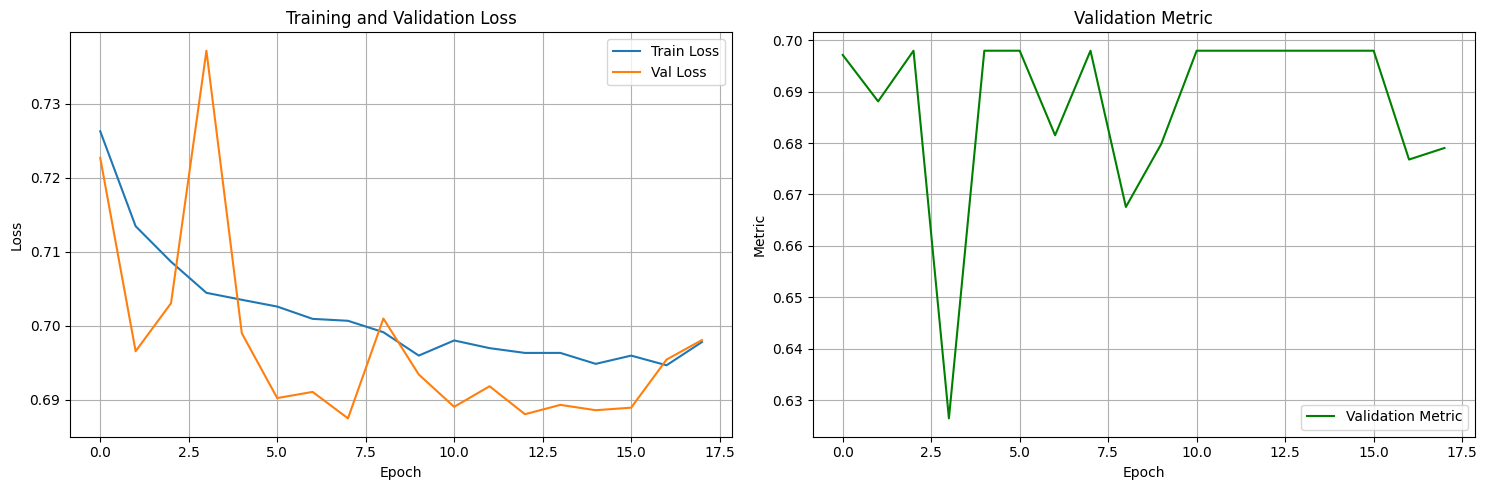

Gráfico salvo em: ./results/simple_cnn_training.png


In [17]:
# Plot curvas de treinamento
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss
axes[0].plot(history['train_loss'], label='Train Loss')
axes[0].plot(history['val_loss'], label='Val Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True)

# Métrica
axes[1].plot(history['val_metric'], label='Validation Metric', color='green')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Metric')
axes[1].set_title('Validation Metric')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.savefig(f"{config['paths']['results_dir']}/{MODEL_TO_TRAIN}_training.png", dpi=300)
plt.show()

print(f"Gráfico salvo em: {config['paths']['results_dir']}/{MODEL_TO_TRAIN}_training.png")

## 12. Salvar Resultados (Opcional)

In [18]:
# Compactar resultados (opcional - útil para backup)
import shutil
from datetime import datetime

# Nome do arquivo com timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
output_file = f"results_{MODEL_TO_TRAIN}_{timestamp}"

# Criar zip
shutil.make_archive(output_file, 'zip', '.', 'checkpoints')
shutil.make_archive(f"{output_file}_plots", 'zip', '.', 'results')

print(f"✓ Resultados salvos:")
print(f"  • {output_file}.zip (checkpoints)")
print(f"  • {output_file}_plots.zip (visualizações)")
print(f"\nTodos os arquivos estão em: {os.path.abspath('.')}")

✓ Resultados salvos:
  • results_simple_cnn_20251213_191805.zip (checkpoints)
  • results_simple_cnn_20251213_191805_plots.zip (visualizações)

Todos os arquivos estão em: /home/luan/Documents/ia_the_movie/notebooks
